Circles data set but in 3d

In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


def make_spheres(
    output_dim,
    n_samples=2000,
    inner_radius=0.5,
    buffer=0.2,
    outer_radius=1.0,
    cross_entropy=False,
    plot=True,
    batch_size=128,
    filename=None,
    random_seed=None,
):
    """
    Generates a dataset of points inside a sphere and in a surrounding shell in 3D.

    Args:
        output_dim (int): Dimension of the output labels (1 for scalar, 2 for one-hot or similar).
        n_samples (int): Total number of points to sample in the cube.
        inner_radius (float): Radius R of the inner sphere.
        buffer (float): Thickness of the empty gap between inner sphere and shell.
        outer_radius (float): Outer radius of the shell (r2).
        cross_entropy (bool): If True, labels are integer class indices; otherwise float targets.
        plot (bool): Whether to show a 3D scatter plot of the filtered data.
        batch_size (int): Batch size for DataLoader.
        filename (str or None): If given, save plot to this filename (without extension).
        random_seed (int or None): Seed for reproducibility.

    Returns:
        train_dataloader, test_dataloader
    """
    # Set seeds
    if random_seed is not None:
        np.random.seed(random_seed)
        torch.manual_seed(random_seed)

    # Sample uniformly in the cube
    coords = np.random.uniform(
        low=-outer_radius,
        high=outer_radius,
        size=(n_samples, 3)
    )

    # Compute distances
    dists = np.linalg.norm(coords, axis=1)

    # Define shell bounds
    shell_min = inner_radius + buffer
    shell_max = outer_radius

    # Select inside sphere and shell points
    mask_inside = dists <= inner_radius
    mask_shell = (dists >= shell_min) & (dists <= shell_max)

    data_inside = coords[mask_inside]
    data_shell = coords[mask_shell]

    # Labels
    if cross_entropy:
        labels_inside = np.zeros(len(data_inside), dtype=np.int64)
        labels_shell = np.ones(len(data_shell), dtype=np.int64)
    else:
        if output_dim == 1:
            labels_inside = -np.ones((len(data_inside), 1), dtype=np.float32)
            labels_shell = np.ones((len(data_shell), 1), dtype=np.float32)
        elif output_dim == 2:
            labels_inside = np.tile([1.0, 0.0], (len(data_inside), 1))
            labels_shell = np.tile([0.0, 1.0], (len(data_shell), 1))
        else:
            raise ValueError("output_dim must be 1 or 2 for non cross_entropy labeling.")

    # Concatenate
    X = np.vstack([data_inside, data_shell])
    y = np.concatenate([labels_inside, labels_shell], axis=0)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=random_seed
    )

    # Plot 3D scatter
    if plot:
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
        # Inside points
        ax.scatter(
            X_train[y_train.flatten() == (0 if cross_entropy else (-1 if output_dim == 1 else 1)), 0],
            X_train[y_train.flatten() == (0 if cross_entropy else (-1 if output_dim == 1 else 1)), 1],
            X_train[y_train.flatten() == (0 if cross_entropy else (-1 if output_dim == 1 else 1)), 2],
            alpha=0.1, label='Inside'
        )
        # Shell points
        ax.scatter(
            X_train[y_train.flatten() == (1 if cross_entropy else (1 if output_dim == 1 else 1)), 0],
            X_train[y_train.flatten() == (1 if cross_entropy else (1 if output_dim == 1 else 1)), 1],
            X_train[y_train.flatten() == (1 if cross_entropy else (1 if output_dim == 1 else 1)), 2],
            alpha=0.1, label='Shell'
        )
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title('3D Dataset: Inner Sphere vs Shell')
        ax.legend()
        if filename:
            plt.savefig(f"{filename}.png", dpi=300, bbox_inches='tight')
        plt.show()

    # Convert to tensors
    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.long if cross_entropy else torch.float32)
    X_test_t = torch.tensor(X_test, dtype=torch.float32)
    y_test_t = torch.tensor(y_test, dtype=torch.long if cross_entropy else torch.float32)

    # DataLoaders
    train_ds = TensorDataset(X_train_t, y_train_t)
    test_ds = TensorDataset(X_test_t, y_test_t)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=len(test_ds), shuffle=False)

    return train_loader, test_loader


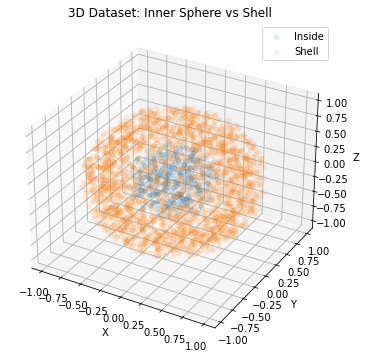

In [2]:
_,_ = make_spheres(1, n_samples=10000, inner_radius=0.5, buffer=0.2, outer_radius=1.0, cross_entropy=False, plot=True, batch_size=128, filename='spheres_3d', random_seed=42)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skimage import measure # For marching cubes
import numpy as np
import copy # For deepcopying model state

# --- Data Generation (adapted from feedforwardexample.ipynb) ---
def generate_spherical_points(n_samples, radius, noise_std=0.05, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    
    # Generate points uniformly on a sphere surface
    phi = np.random.uniform(0, 2 * np.pi, n_samples)
    costheta = np.random.uniform(-1, 1, n_samples)
    theta = np.arccos(costheta)
    
    x = radius * np.sin(theta) * np.cos(phi)
    y = radius * np.sin(theta) * np.sin(phi)
    z = radius * np.cos(theta)
    
    points = np.vstack([x, y, z]).T
    
    if noise_std > 0:
        points += np.random.normal(scale=noise_std, size=points.shape)
        
    return points

def make_spherical_data_3d(n_samples_per_class=1000, radius_inner=0.5, radius_outer=1.0, noise_std=0.1, random_state=None, cross_entropy=True):
    """
    Generates 3D data points on two concentric spheres.
    """
    if random_state is not None:
        np.random.seed(random_state)
        torch.manual_seed(random_state)

    # Generate points for the inner sphere (class 0)
    X_inner = generate_spherical_points(n_samples_per_class, radius_inner, noise_std, random_state)
    y_inner = np.zeros(n_samples_per_class)

    # Generate points for the outer sphere (class 1)
    # Ensure different random state for outer sphere if desired, or chain it
    if random_state is not None:
      X_outer = generate_spherical_points(n_samples_per_class, radius_outer, noise_std, random_state + 1 if random_state is not None else None)
    else:
      X_outer = generate_spherical_points(n_samples_per_class, radius_outer, noise_std, None)
    y_outer = np.ones(n_samples_per_class)

    X = np.vstack((X_inner, X_outer))
    y = np.hstack((y_inner, y_outer)).reshape(-1, 1)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)

    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
    
    if cross_entropy: # Ensure y is suitable for BCELoss
        y_train_tensor = y_train_tensor.float()
        y_test_tensor = y_test_tensor.float()


    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
    
    # Plotting the generated data
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_train[y_train.squeeze() == 0, 0], X_train[y_train.squeeze() == 0, 1], X_train[y_train.squeeze() == 0, 2], label='Class 0 (Train)', alpha=0.3, c='blue')
    ax.scatter(X_train[y_train.squeeze() == 1, 0], X_train[y_train.squeeze() == 1, 1], X_train[y_train.squeeze() == 1, 2], label='Class 1 (Train)', alpha=0.3, c='red')
    ax.set_title('Generated 3D Spherical Data (Train - Scaled)')
    plt.xlabel('X1')
    plt.ylabel('X2')
    ax.set_zlabel('X3')
    plt.legend()
    plt.show()

    return train_loader, test_loader

# --- Model Definition (from feedforwardexample.ipynb) ---
class FFnet(nn.Module):
    def __init__(self, input_dim=2, depth=15, width=2, bottleneck=False, activation='tanh', batchnorm=True): # Added input_dim
        super().__init__()
        if activation == 'tanh':
            act_fn = nn.Tanh
        elif activation == 'relu':
            act_fn = nn.ReLU
        self.activations = []
        layers = []
        in_features = input_dim # Use input_dim

        for i in range(depth):
            out_features = 1 if bottleneck and i == depth - 2 else width # Bottleneck layer before the second to last
            layers.append(nn.Linear(in_features, out_features))
            if batchnorm and i < depth -1: # No batchnorm before output layer if it's the last activation block
                layers.append(nn.BatchNorm1d(out_features))
            if i < depth -1: # No activation after the last linear layer before final output
                 layers.append(act_fn())
            in_features = out_features
        
        layers.append(nn.Linear(in_features, 1))  # Final output layer
        self.net = nn.Sequential(*layers)

    def forward(self, x, collect_activations=False):
        if x.dim() == 1:
            x = x.unsqueeze(0)
        
        # If collecting activations, iterate differently
        if collect_activations:
            self.activations = []
            # Iterate through layers, applying them sequentially
            # For Sequential, we need to handle activation collection carefully
            current_x = x
            for layer_idx, layer_module in enumerate(self.net):
                current_x = layer_module(current_x)
                if isinstance(layer_module, (nn.Tanh, nn.ReLU)):
                    self.activations.append(current_x.detach().cpu().numpy())
            final_output = current_x # The output of the last linear layer
        else:
            # Normal forward pass
            # Iterate up to the layer before the sigmoid activation
            for layer_module in self.net[:-1]: # Exclude the final linear layer from this loop
                 x = layer_module(x)
            final_output = self.net[-1](x) # Apply the final linear layer

        return torch.sigmoid(final_output)


# --- Training Functions (from feedforwardexample.ipynb) ---
def compute_accuracy(y_pred, y_true):
    y_pred_binary = (y_pred >= 0.5).int()
    y_true_binary = y_true.int() # Ensure y_true is also binary
    correct = (y_pred_binary == y_true_binary).sum().item()
    total = y_true.shape[0]
    return correct / total

def train_model(model, train_loader, test_loader,
                epochs=300, lr=0.01, patience=30, batch_size=128): # Reduced patience for faster example
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()
    best_acc = 0
    patience_counter = 0
    losses = []
    best_model_state = None

    for epoch in range(epochs):
        epoch_loss = 0
        for batch_X, batch_y in train_loader:
            y_pred = model(batch_X)
            loss = criterion(y_pred, batch_y)
            epoch_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        avg_epoch_loss = epoch_loss / len(train_loader)
        losses.append(avg_epoch_loss)

        # Evaluate on test data
        model.eval()
        with torch.no_grad():
            acc_summed = 0.
            counter = 0
            for X_test_batch, y_test_batch in test_loader:
                counter += 1
                test_preds = model(X_test_batch)
                acc_summed += compute_accuracy(test_preds, y_test_batch)
            acc = acc_summed / counter
        model.train()

        if epoch % 20 == 0:
             print(f"Epoch {epoch}/{epochs}, Loss: {avg_epoch_loss:.4f}, Accuracy: {acc:.3f}")

        if acc > best_acc:
            best_acc = acc
            best_model_state = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"⏹️ Early stopping at epoch {epoch}, best acc: {best_acc:.3f}")
                break
    
    if best_model_state:
        model.load_state_dict(best_model_state)
    print(f"🏆 Best Test Accuracy: {best_acc:.3f}")
    return model, best_acc, losses

# --- 3D Plotting Function ---
def plot_decision_boundary_3d(model, X_test_numpy, y_test_numpy, title="3D Classification Boundary"):
    model.eval()
    
    # Create a 3D meshgrid for marching cubes
    x_min, x_max = X_test_numpy[:, 0].min() - 0.5, X_test_numpy[:, 0].max() + 0.5
    y_min, y_max = X_test_numpy[:, 1].min() - 0.5, X_test_numpy[:, 1].max() + 0.5
    z_min, z_max = X_test_numpy[:, 2].min() - 0.5, X_test_numpy[:, 2].max() + 0.5
    
    grid_density = 30 # Lower for faster plotting, higher for more detail
    xx, yy, zz = np.meshgrid(np.linspace(x_min, x_max, grid_density),
                             np.linspace(y_min, y_max, grid_density),
                             np.linspace(z_min, z_max, grid_density))
    
    grid_points = np.vstack([xx.ravel(), yy.ravel(), zz.ravel()]).T
    grid_tensor = torch.tensor(grid_points, dtype=torch.float32)

    with torch.no_grad():
        # Model outputs probabilities, reshape to the grid shape
        preds_on_grid_volume = model(grid_tensor).numpy().reshape(xx.shape)

    # Use marching cubes to find the 0.5 isosurface (decision boundary)
    # The verts are in grid coordinates, so we need to scale them
    try:
        verts, faces, _, _ = measure.marching_cubes(preds_on_grid_volume, level=0.5, 
                                                    spacing=((x_max-x_min)/ (grid_density-1),
                                                             (y_max-y_min)/ (grid_density-1),
                                                             (z_max-z_min)/ (grid_density-1)))
        # Translate verts to original coordinate system
        verts += [x_min, y_min, z_min]
    except ValueError: # Handle cases where no surface is found at level 0.5
        print("⚠️ Marching cubes could not find a surface at level 0.5. Plotting scatter only.")
        verts, faces = None, None

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot the decision boundary surface if found
    if verts is not None and faces is not None:
        ax.plot_trisurf(verts[:, 0], verts[:, 1], faces, verts[:, 2],
                        cmap='viridis', alpha=0.3, edgecolor='none')

    # Color points by their true class
    colors = ['blue' if label == 0 else 'red' for label in y_test_numpy.squeeze()]
    ax.scatter(X_test_numpy[:, 0], X_test_numpy[:, 1], X_test_numpy[:, 2], 
               c=colors, edgecolor='k', s=20, label='Test Data (colored by true class)', alpha=0.5)

    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_zlabel('X3')
    ax.set_title(title)
    ax.view_init(elev=30, azim=-60) # Adjust view angle for better visualization
    plt.legend()
    plt.show()

# --- Main Execution ---
if __name__ == '__main__':
    seed = np.random.randint(1000)
    print(f"Using seed: {seed}")
    torch.manual_seed(seed)
    np.random.seed(seed)

    # Generate data
    train_loader, test_loader = make_spherical_data_3d(
        n_samples_per_class=1000, radius_inner=0.6, 
        radius_outer=1.0, noise_std=0.1, cross_entropy=True, random_state=seed
    )

    # Initialize and train the model
    ff_model = FFnet(input_dim=3, depth=5, width=10, bottleneck=False, activation='relu', batchnorm=True) 
    print("\nTraining the model...")
    trained_model, best_accuracy, training_losses = train_model(
        ff_model, train_loader, test_loader, epochs=100, lr=0.005, patience=15
    )

    # Plot training loss
    plt.figure(figsize=(8, 5))
    plt.plot(training_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('BCELoss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot 3D decision surface
    # Extract X_test and y_test from the DataLoader for plotting
    X_test_all = []
    y_test_all = []
    for xb, yb in test_loader:
        X_test_all.append(xb.numpy())
        y_test_all.append(yb.numpy())
    X_test_numpy = np.concatenate(X_test_all)
    y_test_numpy = np.concatenate(y_test_all)
    
    print("\nPlotting 3D decision surface...")
    plot_decision_boundary_3d(trained_model, X_test_numpy, y_test_numpy, title="3D Classification Boundary")



AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations